In [1]:
## Importing Required Libraries
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [4]:
from keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D
from keras.applications import MobileNetV2,InceptionResNetV2,VGG16

ImportError: cannot import name 'MobileNetV2' from 'keras.applications' (C:\Users\Francis.Yego\Anaconda3\lib\site-packages\keras\applications\__init__.py)

In [5]:
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img


In [6]:
## Data Augmentation
train_datagen=ImageDataGenerator(rescale=1/255.0,zoom_range=0.2,shear_range=0.3,horizontal_flip=True,brightness_range=[0.5,1.5])
test_datagen=ImageDataGenerator(rescale=1/255.0)
val_datagen=ImageDataGenerator(rescale=1/255.0)

In [8]:
BATCH_SIZE=32
IMG_SHAPE=(224,224)

In [9]:
train_data=train_datagen.flow_from_directory("face_mask/New Masks Dataset/Train",
                                            target_size=IMG_SHAPE,batch_size=BATCH_SIZE,class_mode="binary")
test_data=train_datagen.flow_from_directory("face_mask/New Masks Dataset/Test",
                                            target_size=IMG_SHAPE,batch_size=BATCH_SIZE,class_mode="binary")
val_data=train_datagen.flow_from_directory("face_mask/New Masks Dataset/Validation",
                                            target_size=IMG_SHAPE,batch_size=BATCH_SIZE,class_mode="binary")

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [9]:
train_data.class_indices

{'Mask': 0, 'Non Mask': 1}

In [10]:
image_class_dict={0:"Mask",1:"Non Mask"}

In [11]:
### Ploting Augmented Images
def plot_random_images():
    images,labels=train_data.next()
    plt.figure(figsize=(20,10))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(image_class_dict[labels[i]])
        

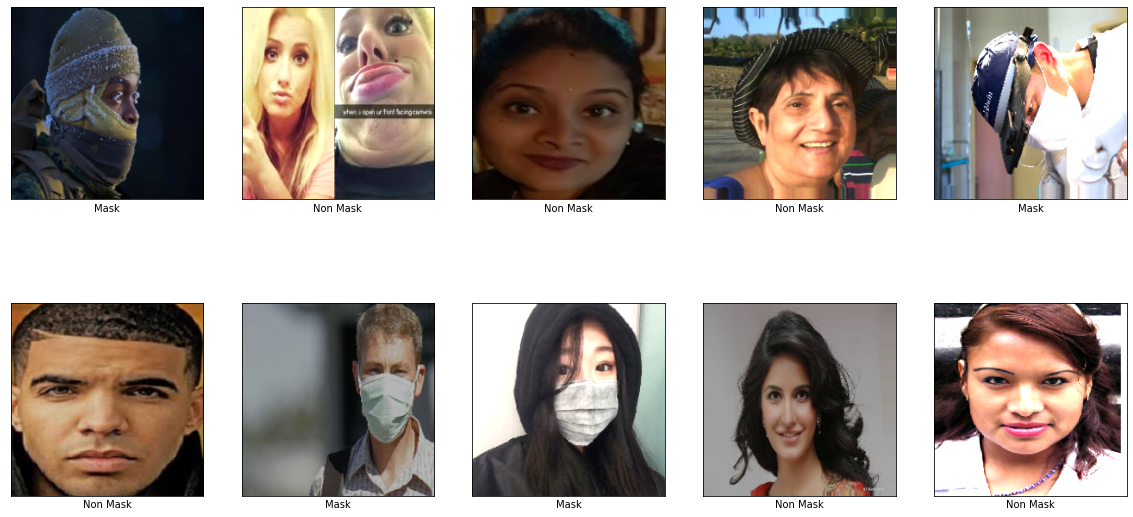

In [12]:
plot_random_images()

In [13]:
### Building Base CNN model

In [14]:
cnn_model=tf.keras.models.Sequential([
    Conv2D(16,3,activation="relu",input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(32,3,activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(64,3,activation="relu"),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(100,activation="relu"),
    Dense(1,activation="sigmoid")
])

In [15]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [16]:
cnn_model.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [17]:
cnn_model.fit_generator(train_data,validation_data=(val_data),epochs=10,steps_per_epoch=18,validation_steps=9)

Epoch 1/10
18/18 [==============================] - 25s 1s/step - loss: 0.8408 - accuracy: 0.5827 - val_loss: 0.5580 - val_accuracy: 0.8229
Epoch 2/10
18/18 [==============================] - 22s 1s/step - loss: 0.4495 - accuracy: 0.7975 - val_loss: 0.4347 - val_accuracy: 0.7986
Epoch 3/10
18/18 [==============================] - 20s 1s/step - loss: 0.4034 - accuracy: 0.8239 - val_loss: 0.3543 - val_accuracy: 0.8715
Epoch 4/10
18/18 [==============================] - 19s 1s/step - loss: 0.2825 - accuracy: 0.8820 - val_loss: 0.2714 - val_accuracy: 0.8889
Epoch 5/10
18/18 [==============================] - 21s 1s/step - loss: 0.2617 - accuracy: 0.9014 - val_loss: 0.3019 - val_accuracy: 0.8785
Epoch 6/10
18/18 [==============================] - 20s 1s/step - loss: 0.2487 - accuracy: 0.8976 - val_loss: 0.2281 - val_accuracy: 0.9097
Epoch 7/10
18/18 [==============================] - 19s 1s/step - loss: 0.2436 - accuracy: 0.9014 - val_loss: 0.2401 - val_accuracy: 0.9097
Epoch 8/10
18/18 [==

In [18]:
600//32

18

In [19]:
306//32

9

In [20]:
cnn_model.evaluate(test_data)

4/4 [==============================] - 2s 489ms/step - loss: 0.2415 - accuracy: 0.9000


[0.24152283370494843, 0.8999999761581421]

In [21]:
## Let's Apply Transfer Learning 

In [22]:
## Let's First Apply VGG16 Architechture

In [23]:
cnn_vgg=VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

58892288/58889256 [==============================] - 1s 0us/step


In [24]:
cnn_vgg.trainable=False

In [25]:
global_avg_pooling=GlobalAveragePooling2D()(cnn_vgg.output)

In [26]:
prediction=Dense(1,activation="sigmoid")(global_avg_pooling)

In [27]:
vgg_model=tf.keras.models.Model(inputs=cnn_vgg.input,outputs=prediction)

In [28]:
vgg_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [29]:
# Defining Model Check Points And Callbacks
early_stop=EarlyStopping(patience=10,monitor="val_accuracy",mode="max")
model_check=ModelCheckpoint(filepath="My_model_vgg.h5",save_best_only=True,monitor="val_accuracy",mode="max",verbose=2)
call_backs=[early_stop,model_check]

In [30]:
vgg_model.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [31]:
vgg_model.fit_generator(train_data,validation_data=(val_data),
                        epochs=60,steps_per_epoch=18,
                        validation_steps=9,callbacks=call_backs)

Epoch 1/60
18/18 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.5898
Epoch 00001: val_accuracy improved from -inf to 0.61458, saving model to My_model_vgg.h5
18/18 [==============================] - 21s 1s/step - loss: 0.6781 - accuracy: 0.5898 - val_loss: 0.6681 - val_accuracy: 0.6146
Epoch 2/60
18/18 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.7165
Epoch 00002: val_accuracy improved from 0.61458 to 0.76042, saving model to My_model_vgg.h5
18/18 [==============================] - 21s 1s/step - loss: 0.6440 - accuracy: 0.7165 - val_loss: 0.6418 - val_accuracy: 0.7604
Epoch 3/60
18/18 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.8003
Epoch 00003: val_accuracy improved from 0.76042 to 0.78472, saving model to My_model_vgg.h5
18/18 [==============================] - 21s 1s/step - loss: 0.6093 - accuracy: 0.8003 - val_loss: 0.6124 - val_accuracy: 0.7847
Epoch 4/60
18/18 [==============================] - ETA: 0

In [32]:
vgg_best_model=tf.keras.models.load_model("My_model_vgg.h5")

In [33]:
vgg_best_model.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [34]:
vgg_best_model.evaluate(test_data)

4/4 [==============================] - 2s 482ms/step - loss: 0.3707 - accuracy: 0.9000


[0.37073078751564026, 0.8999999761581421]

In [35]:
### Let's Perform MobileNet_v2

In [36]:
base_model=MobileNetV2(input_shape=(224,224,3),include_top=False,weights="imagenet")
base_model.trainable=False
global_avg_pooling=GlobalAveragePooling2D()(base_model.output)
prediction=Dense(1,activation="sigmoid")(global_avg_pooling)
mobile_model=tf.keras.models.Model(inputs=base_model.input,outputs=prediction)

9412608/9406464 [==============================] - 0s 0us/step


In [37]:
mobile_model.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [38]:
# Defining Model Check Points And Callbacks
early_stop=EarlyStopping(patience=10,monitor="val_accuracy",mode="max")
model_check=ModelCheckpoint(filepath="My_model_mobile.h5",save_best_only=True,monitor="val_accuracy",mode="max",verbose=2)
call_backs=[early_stop,model_check]

In [39]:

mobile_model.fit_generator(train_data,validation_data=(val_data),
                        epochs=60,steps_per_epoch=18,
                        validation_steps=9,callbacks=call_backs)

Epoch 1/60
18/18 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.7588
Epoch 00001: val_accuracy improved from -inf to 0.88889, saving model to My_model_mobile.h5
18/18 [==============================] - 22s 1s/step - loss: 0.5132 - accuracy: 0.7588 - val_loss: 0.3657 - val_accuracy: 0.8889
Epoch 2/60
18/18 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9560
Epoch 00002: val_accuracy improved from 0.88889 to 0.93403, saving model to My_model_mobile.h5
18/18 [==============================] - 21s 1s/step - loss: 0.2235 - accuracy: 0.9560 - val_loss: 0.2170 - val_accuracy: 0.9340
Epoch 3/60
18/18 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9665
Epoch 00003: val_accuracy improved from 0.93403 to 0.95833, saving model to My_model_mobile.h5
18/18 [==============================] - 20s 1s/step - loss: 0.1410 - accuracy: 0.9665 - val_loss: 0.1532 - val_accuracy: 0.9583
Epoch 4/60
18/18 [==============================]

In [40]:
mobile_best_model=tf.keras.models.load_model("My_model_mobile.h5")

In [41]:
mobile_best_model.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [42]:
mobile_best_model.evaluate(test_data)

4/4 [==============================] - 2s 438ms/step - loss: 0.1026 - accuracy: 0.9800


[0.10258004814386368, 0.9800000190734863]

In [43]:
## Now Let's Apply transfer learning with Inception Resnet_V2

In [44]:
base_model=InceptionResNetV2(input_shape=(224,224,3),include_top=False,weights="imagenet")
base_model.trainable=False
global_avg_pooling=GlobalAveragePooling2D()(base_model.output)
prediction=Dense(1,activation="sigmoid")(global_avg_pooling)
inception_model=tf.keras.models.Model(inputs=base_model.input,outputs=prediction)

219062272/219055592 [==============================] - 3s 0us/step


In [45]:
early_stop=EarlyStopping(patience=10,monitor="val_accuracy",mode="max")
model_check=ModelCheckpoint(filepath="My_model_inception.h5",save_best_only=True,monitor="val_accuracy",mode="max",verbose=2)
call_backs=[early_stop,model_check]

In [46]:
inception_model.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")
inception_model.fit_generator(train_data,validation_data=(val_data),
                        epochs=60,steps_per_epoch=18,
                        validation_steps=9,callbacks=call_backs)

Epoch 1/60
18/18 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.8486
Epoch 00001: val_accuracy improved from -inf to 0.96875, saving model to My_model_inception.h5
18/18 [==============================] - 26s 1s/step - loss: 0.3878 - accuracy: 0.8486 - val_loss: 0.1610 - val_accuracy: 0.9688
Epoch 2/60
18/18 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9718
Epoch 00002: val_accuracy improved from 0.96875 to 0.98264, saving model to My_model_inception.h5
18/18 [==============================] - 23s 1s/step - loss: 0.1033 - accuracy: 0.9718 - val_loss: 0.1035 - val_accuracy: 0.9826
Epoch 3/60
18/18 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9859
Epoch 00003: val_accuracy improved from 0.98264 to 0.98611, saving model to My_model_inception.h5
18/18 [==============================] - 22s 1s/step - loss: 0.0644 - accuracy: 0.9859 - val_loss: 0.0752 - val_accuracy: 0.9861
Epoch 4/60
18/18 [======================

In [47]:
inception_best_model=tf.keras.models.load_model("My_model_inception.h5")
inception_best_model.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")
inception_best_model.evaluate(test_data)

4/4 [==============================] - 2s 437ms/step - loss: 0.0412 - accuracy: 0.9900


[0.0411776602268219, 0.9900000095367432]